# N attractor

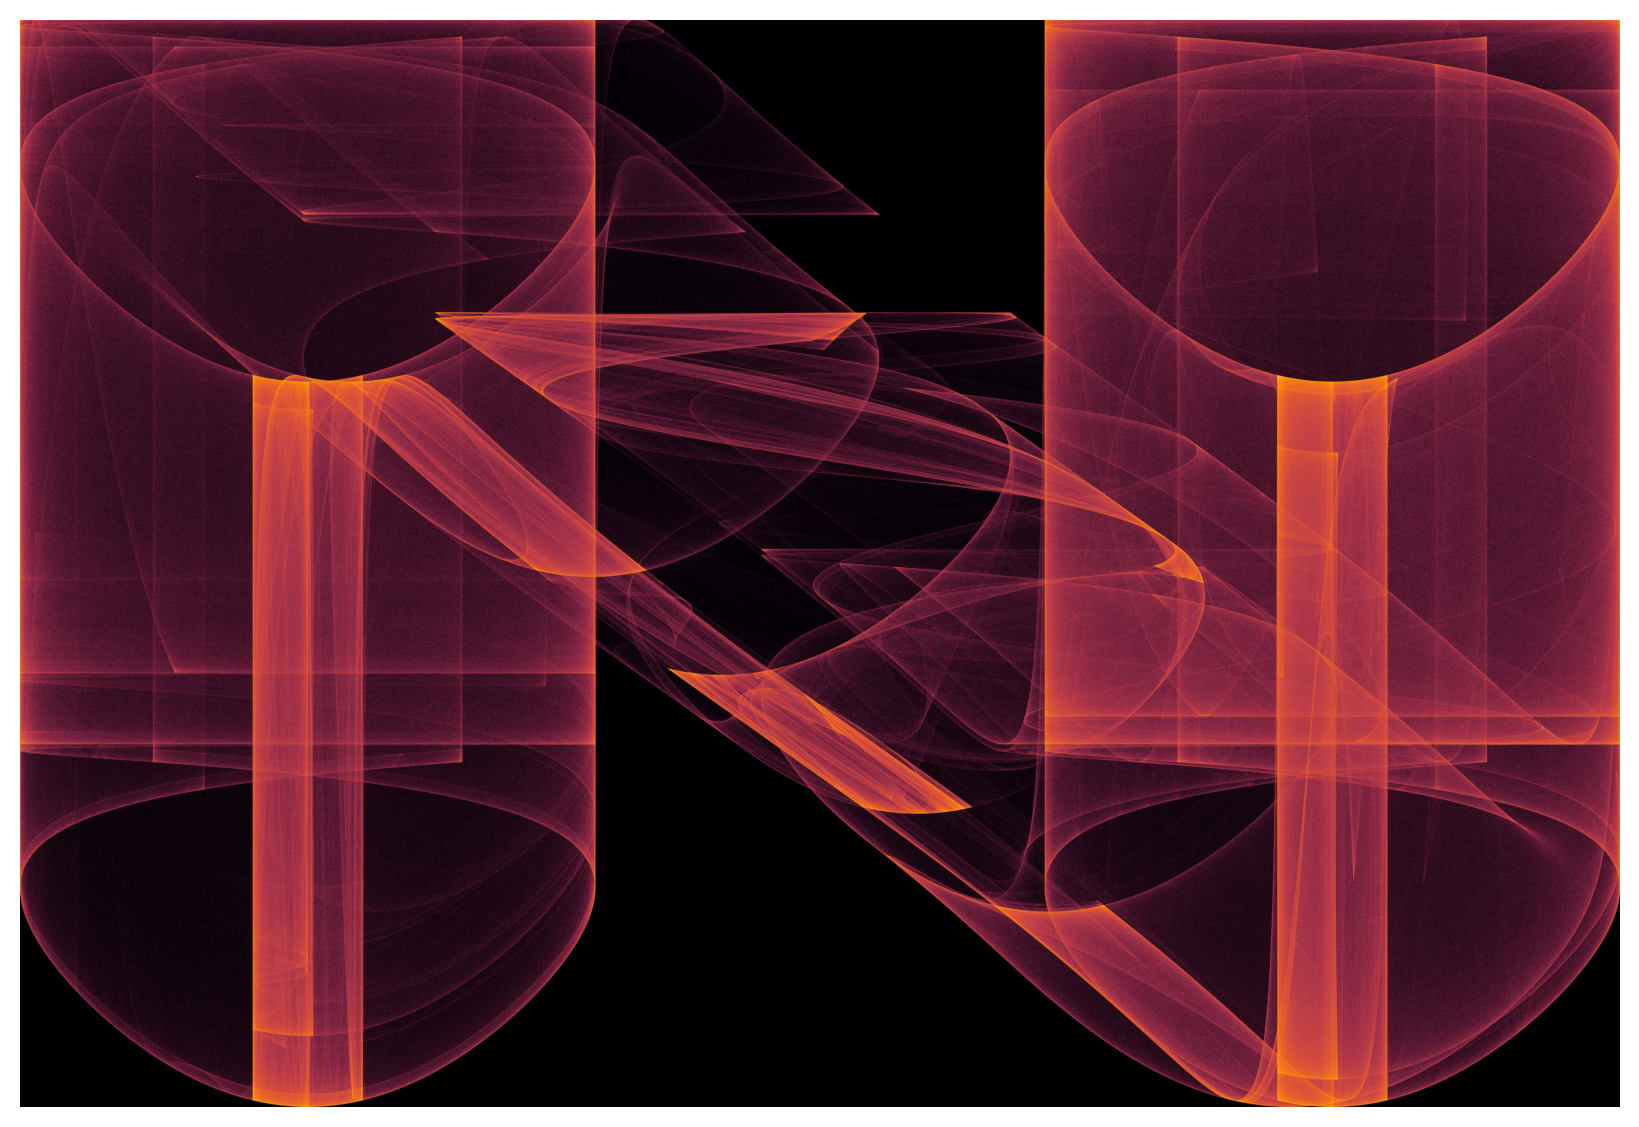

In [24]:
import numpy as np
import matplotlib.pyplot as plt


def n_step(x, y, c0, c1, c2, c3):
    px = x - 0.5 * x * (x*x + 1.0)  
    py = y - 0.5 * y * (y*y + 1.0)  
    x1 = c0 * np.sin(py) + c1 * np.tanh(px)
    y1 = c2 * np.sin(px) + c3 / np.cosh(py)
    return x1, y1

def estimate_bounds(c0, c1, c2, c3, N=300_000, burn=2_000, x0=0.1, y0=0.1, clip=1e-3, pad=0.03):
    xs = np.empty(N, dtype=np.float64)
    ys = np.empty(N, dtype=np.float64)
    x, y = x0, y0
    for n in range(N + burn):
        x, y = n_step(x, y, c0, c1, c2, c3)
        if n >= burn:
            i = n - burn
            xs[i] = x; ys[i] = y
    xmin, xmax = np.quantile(xs, [clip, 1-clip])
    ymin, ymax = np.quantile(ys, [clip, 1-clip])
    dx = max(1e-9, xmax - xmin)
    dy = max(1e-9, ymax - ymin)
    xmin -= pad*dx; xmax += pad*dx
    ymin -= pad*dy; ymax += pad*dy
    return xmin, xmax, ymin, ymax


        return H
else:
    def accumulate_hist(c0, c1, c2, c3, x0, y0, xmin, xmax, ymin, ymax, bins, n_iter, burn):
        H = np.zeros((bins, bins), np.uint32)
        x, y = x0, y0
        sx = (bins - 1.0) / (xmax - xmin)
        sy = (bins - 1.0) / (ymax - ymin)
        for i in range(n_iter + burn):
            x, y = n_step(x, y, c0, c1, c2, c3)
            if i >= burn:
                ix = int((x - xmin) * sx)
                iy = int((y - ymin) * sy)
                if 0 <= ix < bins and 0 <= iy < bins:
                    H[ix, iy] += 1
        return H


                

In [ ]:
# --- Histogram accumulation 
if NUMBA:
    @njit(fastmath=True, cache=True)
    def accumulate_hist(c0, c1, c2, c3, x0, y0, xmin, xmax, ymin, ymax, bins, n_iter, burn):
        H = np.zeros((bins, bins), np.uint32)
        x, y = x0, y0
        sx = (bins - 1.0) / (xmax - xmin)
        sy = (bins - 1.0) / (ymax - ymin)
        for i in range(n_iter + burn):
            # inline the map (numba-friendly)
            px = x - 0.5 * x * (x*x + 1.0)
            py = y - 0.5 * y * (y*y + 1.0)
            x = c0 * np.sin(py) + c1 * np.tanh(px)
            y = c2 * np.sin(px) + c3 / np.cosh(py)
            if i >= burn:
                ix = int((x - xmin) * sx)
                iy = int((y - ymin) * sy)
                if 0 <= ix < bins and 0 <= iy < bins:
                    H[ix, iy] += 1

In [ ]:

def crop_hist(H, xmin, xmax, ymin, ymax, thresh=0):  
    nz = np.argwhere(H > thresh)
    if nz.size == 0:
        return H, (xmin, xmax, ymin, ymax)
    x0, x1 = nz[:,0].min(), nz[:,0].max()
    y0, y1 = nz[:,1].min(), nz[:,1].max()
    Hc = H[x0:x1+1, y0:y1+1]
    bx = H.shape[0] - 1; by = H.shape[1] - 1
    x_lo = xmin + (xmax - xmin) * (x0 / bx)
    x_hi = xmin + (xmax - xmin) * (x1 / bx)
    y_lo = ymin + (ymax - ymin) * (y0 / by)
    y_hi = ymin + (ymax - ymin) * (y1 / by)
    return Hc, (x_lo, x_hi, y_lo, y_hi)

def render_N(c=(1.6831349342542232, -2.9984035545418575, 2.1207267208634164, -2.121518002564899),
             n_iter=5_000_000, burn=10_000, bins=2048, gamma=0.70,
             x0=0.1, y0=0.1, clip=1e-3, pad=0.03, cmap="viridis",
             out_path=None, crop=True):
    
    c0, c1, c2, c3 = map(float, c)
    xmin, xmax, ymin, ymax = estimate_bounds(c0, c1, c2, c3, x0=x0, y0=y0, clip=clip, pad=pad)
    H = accumulate_hist(c0, c1, c2, c3, x0, y0, xmin, xmax, ymin, ymax, bins, n_iter, burn)
    if crop:
        H, (xmin, xmax, ymin, ymax) = crop_hist(H, xmin, xmax, ymin, ymax)

    D = np.log1p(H.astype(np.float64))
    D /= D.max() if D.max() > 0 else 1.0
    D = D**(1.0 - gamma)

    fig = plt.figure(figsize=(8, 8), dpi=200, facecolor="white")
    ax = plt.axes([0,0,1,1], frameon=False); ax.axis("off")
    ax.imshow(D.T, origin="lower",
              extent=(xmin, xmax, ymin, ymax),
              interpolation="bilinear", cmap=cmap)
    plt.savefig("n")

    plt.show()

    if out_path:
        plt.imsave(out_path, D.T, cmap=cmap, origin="lower")  
        print("Saved:", out_path)  

    return (c0, c1, c2, c3)


In [ ]:
_ = render_N(
    c=(1.6831349342542232, -2.9984035545418575, 2.1207267208634164, -2.121518002564899),
    n_iter=200_000_000, burn=12_000, bins=15_000, gamma=0.65, cmap="inferno",
    out_path=None  
)
